## Import Library

In [1]:
# Python Standard Library
import os
import gc
import glob
import time
import json
import shutil
import random
from collections import defaultdict

# Image Processing
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Deep Learning & Model Building (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Model Optimization
import tensorflow_model_optimization as tfmot

# Data Splitting (Scikit-learn)
from sklearn.model_selection import train_test_split

# Progress Tracking
from tqdm import tqdm

# Kaggle Integration
import kagglehub

## EDA

In [ ]:
# Download dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("alessiocorrado99/animals10")
print(f"Dataset downloaded to: {path}")

# Path ke direktori raw-img
raw_img_dir = os.path.join(path, "raw-img")
if not os.path.exists(raw_img_dir):
    # Mencari direktori raw-img jika tidak langsung di root
    possible_dirs = [os.path.join(path, d) for d in os.listdir(path)]
    for d in possible_dirs:
        if os.path.isdir(d) and ("raw-img" in d or "raw" in d):
            raw_img_dir = d
            break

print(f"Menggunakan direktori raw image: {raw_img_dir}")

# Mendapatkan semua direktori kelas (langsung di bawah raw-img)
class_dirs = [d for d in os.listdir(raw_img_dir) if os.path.isdir(os.path.join(raw_img_dir, d))]
print(f"Kelas yang ditemukan: {class_dirs}")

In [ ]:
# Dictionary untuk menyimpan gambar berdasarkan kelas
class_images = defaultdict(list)
all_images = []

# Mengumpulkan gambar dari setiap kelas
for class_name in class_dirs:
    class_path = os.path.join(raw_img_dir, class_name)
    # Mengumpulkan semua file gambar dalam direktori kelas
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        images.extend(glob.glob(os.path.join(class_path, ext)))

    class_images[class_name] = images
    all_images.extend(images)
    print(f"Kelas {class_name}: {len(images)} gambar")

print(f"\nTotal gambar ditemukan: {len(all_images)}")

In [ ]:
# Memeriksa resolusi gambar
resolutions = []
for img_path in random.sample(all_images, min(len(all_images), 500)):  # Sample untuk efisiensi
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            resolutions.append((width, height))
    except Exception as e:
        print(f"Error opening {img_path}: {e}")

# Menampilkan statistik resolusi
if resolutions:
    widths, heights = zip(*resolutions)
    print(f"\nResolusi gambar (dari {len(resolutions)} sampel):")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
else:
    print("Tidak dapat mendapatkan informasi resolusi dari gambar.")

In [ ]:
# Visualisasi distribusi kelas
plt.figure(figsize=(12, 6))
class_names = list(class_images.keys())
class_counts = [len(images) for images in class_images.values()]

# Sorting berdasarkan jumlah gambar
sorted_indices = np.argsort(class_counts)[::-1]
sorted_names = [class_names[i] for i in sorted_indices]
sorted_counts = [class_counts[i] for i in sorted_indices]

# Membuat bar plot
sns.barplot(x=sorted_names, y=sorted_counts)
plt.title('Distribusi Jumlah Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Fungsi untuk menampilkan contoh gambar
def show_examples(class_images, num_examples=2):
    n_classes = len(class_images)
    fig = plt.figure(figsize=(15, n_classes * 4))
    gs = GridSpec(n_classes, num_examples, figure=fig)

    for i, (class_name, images) in enumerate(class_images.items()):
        if not images:
            print(f"Tidak ada gambar untuk kelas {class_name}")
            continue

        sample_images = random.sample(images, min(num_examples, len(images)))

        for j, img_path in enumerate(sample_images):
            try:
                img = Image.open(img_path)
                ax = fig.add_subplot(gs[i, j])
                ax.imshow(img)
                ax.set_title(f"{class_name}")
                ax.axis('off')
            except Exception as e:
                print(f"Error displaying {img_path}: {e}")

    plt.tight_layout()
    plt.suptitle('Contoh 2 Gambar dari Setiap Kelas', fontsize=16, y=1.02)
    plt.show()

# Menampilkan contoh gambar
show_examples(class_images, num_examples=2)

# Menampilkan statistik tambahan
print("\nStatistik Dataset:")
print(f"Jumlah kelas: {len(class_images)}")
print(f"Jumlah total gambar: {len(all_images)}")
print("Distribusi kelas:")
for class_name, images in sorted(class_images.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  - {class_name}: {len(images)} gambar ({len(images)/len(all_images)*100:.1f}%)")

## Preprosesing

In [ ]:
# Fungsi untuk membagi dataset menjadi train, validation, dan test
def split_dataset(src_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Membagi dataset menjadi train, validation, dan test

    Args:
        src_dir: Direktori dataset sumber dengan struktur /raw-img/class/images
        output_dir: Direktori output untuk menyimpan dataset yang telah dibagi
        train_ratio, val_ratio, test_ratio: Rasio pembagian dataset
        seed: Random seed untuk reproducibility
    """
    # Validasi rasio
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-10, "Rasio harus berjumlah 1"

    # Inisialisasi random seed
    random.seed(seed)
    np.random.seed(seed)

    # Membuat direktori output jika belum ada
    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    # Membuat direktori train, val, test
    for dir_path in [train_dir, val_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)

    # Mendapatkan raw-img directory
    if 'raw-img' in os.listdir(src_dir):
        raw_img_dir = os.path.join(src_dir, 'raw-img')
    else:
        # Coba cari direktori raw-img atau raw
        for dir_name in os.listdir(src_dir):
            if os.path.isdir(os.path.join(src_dir, dir_name)) and ('raw-img' in dir_name or 'raw' in dir_name):
                raw_img_dir = os.path.join(src_dir, dir_name)
                break
        else:
            # Asumsi src_dir sudah berisi direktori kelas
            raw_img_dir = src_dir

    # Mendapatkan semua kelas (folder dalam raw_img_dir)
    class_dirs = [d for d in os.listdir(raw_img_dir) if os.path.isdir(os.path.join(raw_img_dir, d))]

    total_files = 0
    class_counts = {}

    # Untuk setiap kelas
    for class_name in tqdm(class_dirs, desc="Processing classes"):
        # Buat folder kelas di setiap split
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Dapatkan semua file gambar dalam folder kelas
        class_path = os.path.join(raw_img_dir, class_name)
        image_files = []

        # Cari semua file gambar
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            import glob
            image_files.extend(glob.glob(os.path.join(class_path, ext)))

        class_counts[class_name] = len(image_files)
        total_files += len(image_files)

        # Kocok file gambar
        random.shuffle(image_files)

        # Bagi menjadi train, val, test
        n_train = int(len(image_files) * train_ratio)
        n_val = int(len(image_files) * val_ratio)

        train_files = image_files[:n_train]
        val_files = image_files[n_train:n_train + n_val]
        test_files = image_files[n_train + n_val:]

        # Fungsi untuk menyalin file
        def copy_files(files, dest_dir):
            for file_path in files:
                file_name = os.path.basename(file_path)
                dest_path = os.path.join(dest_dir, class_name, file_name)
                shutil.copy2(file_path, dest_path)

        # Salin file ke direktori masing-masing
        copy_files(train_files, train_dir)
        copy_files(val_files, val_dir)
        copy_files(test_files, test_dir)

    # Tampilkan statistik
    print(f"Total files: {total_files}")
    print("Class distribution:")
    for class_name, count in class_counts.items():
        print(f"  - {class_name}: {count} images")

    print(f"\nSplit statistics:")
    print(f"  - Training: {sum(len(os.listdir(os.path.join(train_dir, c))) for c in class_dirs)} images")
    print(f"  - Validation: {sum(len(os.listdir(os.path.join(val_dir, c))) for c in class_dirs)} images")
    print(f"  - Testing: {sum(len(os.listdir(os.path.join(test_dir, c))) for c in class_dirs)} images")

    return train_dir, val_dir, test_dir

In [ ]:
# Fungsi preprocessing yang efisien menggunakan TensorFlow
def create_preprocessing_function(target_size=(224, 224), normalize=True):
    """
    Membuat fungsi preprocessing untuk gambar

    Args:
        target_size: Ukuran target gambar (width, height)
        normalize: Boolean untuk normalisasi nilai piksel ke range [0,1]

    Returns:
        Fungsi preprocessing
    """
    def preprocess_image(image_path):
        # Baca gambar dari file
        img = tf.io.read_file(image_path)
        # Decode gambar
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        # Resize
        img = tf.image.resize(img, target_size)
        # Normalisasi jika diperlukan
        if normalize:
            img = img / 255.0
        return img

    return preprocess_image

In [ ]:
# Generator data untuk training dengan augmentasi dan efisien RAM
def create_efficient_data_generators(train_dir, val_dir, test_dir,
                                    batch_size=32,
                                    target_size=(224, 224),
                                    balance_classes=True,
                                    seed=42):
    """
    Membuat generator data yang efisien untuk training, validation dan testing

    Args:
        train_dir, val_dir, test_dir: Direktori dataset
        batch_size: Ukuran batch
        target_size: Ukuran target gambar
        balance_classes: Apakah menyeimbangkan kelas atau tidak
        seed: Random seed

    Returns:
        train_generator, val_generator, test_generator
    """
    # Generator data dasar untuk validation dan test (tanpa augmentasi)
    base_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Generator data untuk training dengan augmentasi
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Mendapatkan jumlah sample per kelas untuk kelas balancing
    if balance_classes:
        class_weights = {}
        class_counts = {}
        class_dirs = os.listdir(train_dir)
        max_samples = 0

        # Hitung jumlah sampel per kelas
        for class_name in class_dirs:
            class_path = os.path.join(train_dir, class_name)
            if os.path.isdir(class_path):
                n_samples = len([f for f in os.listdir(class_path)
                                if os.path.isfile(os.path.join(class_path, f))])
                class_counts[class_name] = n_samples
                max_samples = max(max_samples, n_samples)

        # Hitung weights untuk class balancing
        total = sum(class_counts.values())
        for cls, count in class_counts.items():
            class_weights[cls] = total / (len(class_counts) * count)

        print("Class weights for balancing:")
        for cls, weight in class_weights.items():
            print(f"  - {cls}: {weight:.4f}")
    else:
        class_weights = None

    # Buat generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed
    )

    val_generator = base_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = base_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator, class_weights

In [ ]:
# Fungsi untuk memperlihatkan contoh hasil augmentasi
def show_augmentation_examples(train_dir, n_samples=1, target_size=(224, 224)):
    """
    Menampilkan contoh hasil augmentasi gambar

    Args:
        train_dir: Direktori training
        n_samples: Jumlah sampel per kelas
        target_size: Ukuran target gambar
    """
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    n_classes = len(class_dirs)

    plt.figure(figsize=(15, n_classes * 2))

    for i, class_name in enumerate(class_dirs):
        # Ambil satu gambar contoh
        class_path = os.path.join(train_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if not image_files:
            continue

        sample_image_path = os.path.join(class_path, random.choice(image_files))

        # Baca dan preprocess gambar
        img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=target_size)
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmentasi
        aug_iter = datagen.flow(x, batch_size=1)

        # Plot original dan augmented
        plt.subplot(n_classes, n_samples + 1, i * (n_samples + 1) + 1)
        plt.imshow(img)
        plt.title(f"{class_name} (original)")
        plt.axis('off')

        for j in range(n_samples):
            aug_img = next(aug_iter)[0]
            plt.subplot(n_classes, n_samples + 1, i * (n_samples + 1) + j + 2)
            plt.imshow(aug_img)
            plt.title(f"{class_name} (augmented)")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Bersihkan memori
    gc.collect()

In [ ]:
# Contoh penggunaan:
if __name__ == "__main__":
    src_dir = path # use path variable from kagglehub.dataset_download
    output_dir = "/path/to/animals10/split_dataset"

    # Split dataset
    train_dir, val_dir, test_dir = split_dataset(
        src_dir,
        output_dir,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15
    )

    # Buat generators yang efisien
    train_generator, val_generator, test_generator, class_weights = create_efficient_data_generators(
        train_dir,
        val_dir,
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        balance_classes=True
    )

    # Tampilkan contoh augmentasi
    show_augmentation_examples(train_dir, n_samples=3)

## Modeling

In [ ]:
# Mengatur GPU jika tersedia (opsional)
def setup_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU tersedia: {len(gpus)}")
        except RuntimeError as e:
            print(f"Error saat mengkonfigurasi GPU: {e}")
    else:
        print("Tidak ada GPU tersedia. Menggunakan CPU.")

In [ ]:
# Fungsi untuk membangun model dengan MobileNetV2 sebagai base model
def build_mobilenetv2_sequential_model(input_shape=(224, 224, 3), num_classes=10, trainable_base=False):
    """
    Membuat model dengan MobileNetV2 sebagai base model, dikombinasikan dengan Conv2D dan Dense layers

    Args:
        input_shape: Bentuk input (tinggi, lebar, channel)
        num_classes: Jumlah kelas output
        trainable_base: Boolean untuk mengaktifkan training pada base model

    Returns:
        Model Keras yang sudah dikompilasi
    """
    # Load base model MobileNetV2 tanpa include_top (tanpa fully connected layers)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Set apakah base model dapat dilatih atau tidak
    base_model.trainable = trainable_base

    # Buat model Sequential baru
    model = Sequential([
        # Base model
        base_model,

        # Menambahkan Conv2D layers
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),

        # Pooling layer
        GlobalAveragePooling2D(),

        # Dense layers
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Fungsi untuk training model
def train_model(model, train_generator, val_generator, output_dir,
                batch_size=32, epochs=50, class_weights=None):
    """
    Melatih model dengan callback untuk early stopping, model checkpoint, dan reduce LR

    Args:
        model: Model Keras yang sudah dikompilasi
        train_generator, val_generator: Generator data untuk training dan validasi
        output_dir: Direktori untuk menyimpan output model dan plot
        batch_size: Ukuran batch
        epochs: Jumlah maksimum epoch
        class_weights: Bobot kelas untuk balancing (jika ada)

    Returns:
        History object dan path ke model terbaik
    """
    # Buat direktori output jika belum ada
    os.makedirs(output_dir, exist_ok=True)

    # Path untuk menyimpan model terbaik
    best_model_path = os.path.join(output_dir, 'best_model.h5')

    # Callback untuk early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    # Callback untuk model checkpoint
    model_checkpoint = ModelCheckpoint(
        best_model_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    # Callback untuk reduce learning rate
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Lista semua callbacks
    callbacks = [early_stopping, model_checkpoint, reduce_lr]

    # Log training waktu mulai
    start_time = time.time()

    # Training model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        # workers=4,  # Sesuaikan dengan jumlah core CPU
        # use_multiprocessing=True,  # Aktifkan multiprocessing untuk efisiensi
        verbose=1
    )

    # Waktu training
    training_time = time.time() - start_time
    print(f"Training selesai dalam {training_time/60:.2f} menit")

    return history, best_model_path

In [ ]:
# Fungsi untuk plot training history
def plot_training_history(history, output_dir):
    """
    Plot accuracy dan loss dari training history

    Args:
        history: History object dari model.fit()
        output_dir: Direktori untuk menyimpan plot
    """
    # Buat direktori output jika belum ada
    os.makedirs(output_dir, exist_ok=True)

    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.show()

    # Plot learning rate jika tersedia
    if 'lr' in history.history:
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.savefig(os.path.join(output_dir, 'learning_rate.png'))
        plt.show()

In [ ]:
# Fungsi untuk evaluasi model
def evaluate_model(model, test_generator):
    """
    Evaluasi model menggunakan test generator

    Args:
        model: Model Keras yang sudah dilatih
        test_generator: Generator data untuk testing

    Returns:
        Hasil evaluasi (loss dan accuracy)
    """
    # Reset generator untuk memastikan evaluasi dimulai dari awal
    test_generator.reset()

    # Evaluasi model
    results = model.evaluate(test_generator, verbose=1)

    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")

    return results

In [ ]:
# Fungsi utama
def main(train_dir, val_dir, test_dir, output_dir,
         img_size=(224, 224), batch_size=32, epochs=50,
         balance_classes=True):
    """
    Fungsi utama untuk training model

    Args:
        train_dir, val_dir, test_dir: Direktori dataset
        output_dir: Direktori untuk menyimpan output
        img_size: Ukuran gambar input
        batch_size: Ukuran batch
        epochs: Jumlah maksimum epoch
        balance_classes: Boolean untuk mengaktifkan class balancing
    """
    # Setup GPU jika tersedia
    setup_gpu()

    # Buat directori output jika belum ada
    os.makedirs(output_dir, exist_ok=True)

    # Data generator untuk training dengan augmentasi
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Data generator untuk validation dan test (hanya rescaling)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Buat generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Dapatkan jumlah kelas
    num_classes = len(train_generator.class_indices)
    print(f"Jumlah kelas: {num_classes}")
    print(f"Label kelas: {train_generator.class_indices}")

    # Hitung class weights jika diperlukan
    if balance_classes:
        class_counts = [0] * num_classes
        for i in range(len(train_generator.classes)):
            class_counts[train_generator.classes[i]] += 1

        total = sum(class_counts)
        class_weights = {i: total / (num_classes * count) for i, count in enumerate(class_counts)}

        print("Class weights:")
        for cls, weight in class_weights.items():
            class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(cls)]
            print(f"  - {class_name} ({cls}): {weight:.4f}")
    else:
        class_weights = None

    # Buat model
    input_shape = (*img_size, 3)  # (height, width, channels)
    model = build_mobilenetv2_sequential_model(
        input_shape=input_shape,
        num_classes=num_classes
    )

    # Ringkasan model
    model.summary()

    # Plot model architecture (opsional)
    try:
        plot_model(model, to_file=os.path.join(output_dir, 'model_architecture.png'), show_shapes=True)
    except:
        print("Tidak dapat membuat plot model, GraphViz mungkin tidak terinstall.")

    # Train model
    history, best_model_path = train_model(
        model=model,
        train_generator=train_generator,
        val_generator=val_generator,
        output_dir=output_dir,
        batch_size=batch_size,
        epochs=epochs,
        class_weights=class_weights
    )

    # Plot training history
    plot_training_history(history, output_dir)

    # Load model terbaik untuk evaluasi
    print(f"Loading model terbaik dari: {best_model_path}")
    best_model = tf.keras.models.load_model(best_model_path)

    # Evaluasi model
    test_results = evaluate_model(best_model, test_generator)

    # Tampilkan laporan hasil
    print("\nLaporan Training:")
    print(f"- Model disimpan di: {best_model_path}")
    print(f"- Akurasi training terakhir: {history.history['accuracy'][-1]:.4f}")
    print(f"- Akurasi validasi terakhir: {history.history['val_accuracy'][-1]:.4f}")
    print(f"- Akurasi validasi terbaik: {max(history.history['val_accuracy']):.4f}")
    print(f"- Akurasi test: {test_results[1]:.4f}")

    # Bersihkan memori
    gc.collect()

    return best_model, history, test_results

In [ ]:
# Contoh penggunaan
if __name__ == "__main__":
    # Ganti dengan path yang sesuai
    train_dir = "/path/to/animals10/split_dataset/train"
    val_dir = "/path/to/animals10/split_dataset/val"
    test_dir = "/path/to/animals10/split_dataset/test"
    output_dir = "/path/to/animals10/model_output"

    # Jalankan training
    best_model, history, test_results = main(
        train_dir=train_dir,
        val_dir=val_dir,
        test_dir=test_dir,
        output_dir=output_dir,
        img_size=(224, 224),
        batch_size=32,
        epochs=50,
        balance_classes=True
    )

## Evaluasi Model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_and_print_metrics(model, test_generator):
    """Evaluates the model and prints the classification report and confusion matrix."""

    # Predict on the test data
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix (optional, for visualization)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(test_generator.class_indices.keys()),
                yticklabels=list(test_generator.class_indices.keys()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage (assuming 'best_model' and 'test_generator' are defined)
evaluate_and_print_metrics(best_model, test_generator)


## Menyimpan Model

In [ ]:
def create_directory_structure(base_dir):
    """
    Membuat struktur direktori sesuai yang diminta

    Args:
        base_dir: Direktori dasar untuk menyimpan semua model
    """
    # Buat direktori utama jika belum ada
    os.makedirs(base_dir, exist_ok=True)

    # Buat subdirektori
    tfjs_dir = os.path.join(base_dir, 'tfjs_model')
    tflite_dir = os.path.join(base_dir, 'tflite')
    saved_model_dir = os.path.join(base_dir, 'saved_model')

    # Buat subdirektori jika belum ada
    for directory in [tfjs_dir, tflite_dir, saved_model_dir]:
        os.makedirs(directory, exist_ok=True)

    print(f"Struktur direktori berhasil dibuat di: {base_dir}")
    return tfjs_dir, tflite_dir, saved_model_dir

In [ ]:
def get_class_labels(train_dir):
    """
    Mendapatkan label kelas dari direktori training

    Args:
        train_dir: Direktori training data

    Returns:
        Dictionary label kelas
    """
    class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}
    return class_indices

In [ ]:
def save_to_saved_model(model, saved_model_dir):
    """
    Menyimpan model dalam format SavedModel

    Args:
        model: Model Keras yang akan disimpan
        saved_model_dir: Direktori untuk menyimpan model

    Returns:
        Path ke saved model
    """
    # Hapus direktori jika sudah ada untuk menghindari error
    if os.path.exists(saved_model_dir):
        shutil.rmtree(saved_model_dir)

    # Simpan model using tf.saved_model.save
    # which is how to make a SavedModel
    tf.saved_model.save(model, saved_model_dir)

    print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_dir}")

    # Verifikasi model tersimpan
    print(f"Isi direktori SavedModel:")
    for item in os.listdir(saved_model_dir):
        print(f"- {item}")

    return saved_model_dir

In [ ]:
def convert_to_tflite(model, tflite_dir, class_indices, optimize=True):
    """
    Mengkonversi model ke format TFLite

    Args:
        model: Model Keras yang akan dikonversi
        tflite_dir: Direktori untuk menyimpan model TFLite
        class_indices: Dictionary label kelas
        optimize: Boolean untuk mengaktifkan optimisasi

    Returns:
        Path ke model TFLite
    """
    # Path untuk model TFLite
    tflite_model_path = os.path.join(tflite_dir, 'model.tflite')

    # Konverter TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Opsi optimisasi
    if optimize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Konversi model
    tflite_model = converter.convert()

    # Simpan model TFLite
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f"Model berhasil dikonversi ke TFLite di: {tflite_model_path}")

    # Simpan label kelas
    label_path = os.path.join(tflite_dir, 'label.txt')

    # Sort label berdasarkan indeks
    sorted_labels = [k for k, v in sorted(class_indices.items(), key=lambda item: item[1])]

    with open(label_path, 'w') as f:
        for label in sorted_labels:
            f.write(f"{label}\n")

    print(f"Label kelas berhasil disimpan di: {label_path}")

    # Tampilkan ukuran model
    tflite_model_size = os.path.getsize(tflite_model_path) / (1024 * 1024)
    print(f"Ukuran model TFLite: {tflite_model_size:.2f} MB")

    return tflite_model_path

In [ ]:
def convert_to_tfjs(model, tfjs_dir):
    """
    Mengkonversi model ke format TensorFlow.js

    Args:
        model: Model Keras yang akan dikonversi
        tfjs_dir: Direktori untuk menyimpan model TFJS

    Returns:
        Path ke direktori model TFJS
    """
    # Import tensorflowjs
    try:
        import tensorflowjs as tfjs
    except ImportError:
        print("Modul tensorflowjs tidak ditemukan. Menginstal...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'tensorflowjs'])
        import tensorflowjs as tfjs

    # Hapus direktori jika sudah ada untuk menghindari error
    if os.path.exists(tfjs_dir):
        shutil.rmtree(tfjs_dir)

    # Konversi ke format TensorFlow.js
    tfjs.converters.save_keras_model(model, tfjs_dir)
    print(f"Model berhasil dikonversi ke TensorFlow.js di: {tfjs_dir}")

    # Verifikasi file yang dihasilkan
    print(f"File yang dihasilkan di direktori TFJS:")
    for item in os.listdir(tfjs_dir):
        print(f"- {item}")

    return tfjs_dir

In [ ]:
def create_model_metadata(base_dir, saved_model_dir, tflite_path, tfjs_dir, class_indices, img_size=(224, 224)):
    """
    Membuat file metadata yang berisi informasi model

    Args:
        base_dir: Direktori dasar
        saved_model_dir: Path ke SavedModel
        tflite_path: Path ke model TFLite
        tfjs_dir: Path ke direktori model TFJS
        class_indices: Dictionary label kelas
        img_size: Ukuran input image
    """
    metadata = {
        "model_info": {
            "base_model": "MobileNetV2",
            "input_shape": list(img_size) + [3],  # [height, width, channels]
            "num_classes": len(class_indices),
            "preprocessing": "Rescale 1/255"
        },
        "class_labels": {str(v): k for k, v in class_indices.items()},
        "exported_formats": {
            "saved_model": os.path.relpath(saved_model_dir, base_dir),
            "tflite": os.path.relpath(tflite_path, base_dir),
            "tfjs": os.path.relpath(tfjs_dir, base_dir)
        }
    }

    # Simpan metadata ke file JSON
    metadata_path = os.path.join(base_dir, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Metadata model berhasil disimpan di: {metadata_path}")

    return metadata_path

In [ ]:
def export_model_to_all_formats(model_path, base_dir, train_dir, img_size=(224, 224)):
    """
    Fungsi utama untuk mengkonversi model ke semua format

    Args:
        model_path: Path ke model Keras (.h5)
        base_dir: Direktori dasar untuk menyimpan model
        train_dir: Direktori training data (untuk mendapatkan label kelas)
        img_size: Ukuran input image

    Returns:
        Dictionary dengan path ke semua model yang diekspor
    """
    print(f"Memulai konversi model dari: {model_path}")

    # Buat struktur direktori
    tfjs_dir, tflite_dir, saved_model_dir = create_directory_structure(base_dir)

    # Load model
    print("Loading model...")
    model = load_model(model_path)
    print("Model berhasil dimuat")

    # Mendapatkan label kelas
    class_indices = get_class_labels(train_dir)
    print(f"Ditemukan {len(class_indices)} kelas: {list(class_indices.keys())}")

    # Ekspor ke SavedModel
    saved_model_path = save_to_saved_model(model, saved_model_dir)

    # Konversi ke TFLite
    tflite_path = convert_to_tflite(model, tflite_dir, class_indices)

    # Konversi ke TensorFlow.js
    tfjs_path = convert_to_tfjs(model, tfjs_dir)

    # Buat metadata
    metadata_path = create_model_metadata(
        base_dir, saved_model_path, tflite_path, tfjs_path, class_indices, img_size
    )

    # Buat dictionary berisi semua path
    result = {
        "saved_model": saved_model_path,
        "tflite": tflite_path,
        "tfjs": tfjs_path,
        "metadata": metadata_path
    }

    print("\nKonversi model selesai!")
    print(f"Semua format tersimpan di: {base_dir}")

    return result

In [ ]:
if __name__ == "__main__":
    # Ganti dengan path yang sesuai
    model_path = "/path/to/animals10/model_output/best_model.h5"
    base_dir = "/path/to/exported_models"  # Direktori untuk menyimpan model yang diekspor
    train_dir = "/path/to/animals10/split_dataset/train" # Update the train_dir to the actual path

    # Ekspor model ke semua format
    result = export_model_to_all_formats(model_path, base_dir, train_dir)


 ## Inference

In [ ]:
def test_keras_model(model_path, image_path, class_indices=None, label_path=None, img_size=(224, 224)):
    """
    Melakukan inferensi dengan model Keras (.h5 atau SavedModel)

    Args:
        model_path: Path ke model Keras (.h5) atau direktori SavedModel
        image_path: Path ke gambar yang akan diuji
        class_indices: Dictionary label kelas (opsional jika label_path disediakan)
        label_path: Path ke file label.txt (opsional jika class_indices disediakan)
        img_size: Ukuran input gambar (default: (224, 224))

    Returns:
        tuple: (class_name, confidence, predictions)
    """
    # Pastikan kita memiliki label kelas
    class_names = None
    if class_indices:
        # Gunakan class_indices yang diberikan (hasil dari ImageDataGenerator)
        class_names = {v: k for k, v in class_indices.items()}
    elif label_path and os.path.exists(label_path):
        # Baca dari file label.txt
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f.readlines()]
            class_names = {i: label for i, label in enumerate(labels)}
    else:
        raise ValueError("Memerlukan class_indices atau label_path yang valid")

    # Load dan preprocess gambar
    img = load_img(image_path, target_size=img_size)
    x = img_to_array(img)
    x = x / 255.0  # Normalisasi [0-1]
    x = np.expand_dims(x, axis=0)

    # Load model
    model = load_model(model_path)

    # Prediksi
    predictions = model.predict(x)

    # Dapatkan label kelas
    class_idx = np.argmax(predictions[0])
    class_name = class_names[class_idx]
    confidence = predictions[0][class_idx]

    # Tampilkan hasil
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {class_name} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

    print(f"Prediksi: {class_name}")
    print(f"Confidence: {confidence:.4f}")
    
    # Tampilkan semua kelas dan probabilitasnya
    print("\nProbabilitas semua kelas:")
    for i, prob in enumerate(predictions[0]):
        if i in class_names:
            print(f"{class_names[i]}: {prob:.4f}")
            
    return class_name, confidence, predictions[0]


In [3]:
def test_tflite_model(tflite_path, image_path, label_path, img_size=(224, 224)):
    """
    Melakukan inferensi dengan model TFLite

    Args:
        tflite_path: Path ke model TFLite
        image_path: Path ke gambar yang akan diuji
        label_path: Path ke file label.txt
        img_size: Ukuran input gambar

    Returns:
        tuple: (class_name, confidence, predictions)
    """
    # Load labels
    with open(label_path, 'r') as f:
        labels = [line.strip() for line in f.readlines()]

    # Load dan preprocess gambar
    img = load_img(image_path, target_size=img_size)
    x = img_to_array(img)
    x = x / 255.0  # Normalisasi [0-1]
    x = np.expand_dims(x, axis=0)
    x = x.astype(np.float32)

    # Load model TFLite dan alokasikan tensor
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    # Dapatkan input dan output tensor
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], x)

    # Jalankan inferensi
    interpreter.invoke()

    # Dapatkan output tensor
    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Dapatkan hasil
    class_idx = np.argmax(predictions[0])
    class_name = labels[class_idx]
    confidence = predictions[0][class_idx]

    # Tampilkan hasil
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"TFLite Predicted: {class_name} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

    print(f"Prediksi TFLite: {class_name}")
    print(f"Confidence: {confidence:.4f}")

    # Tampilkan semua kelas dan probabilitasnya
    print("\nProbabilitas semua kelas (TFLite):")
    for i, prob in enumerate(predictions[0]):
        print(f"{labels[i]}: {prob:.4f}")

    return class_name, confidence, predictions[0]


In [ ]:
# Fungsi pembungkus untuk memudahkan penggunaan
def infer_image(image_path, model_type='keras', model_path=None, class_indices=None,
               label_path=None, tflite_path=None, img_size=(224, 224)):
    """
    Fungsi pembungkus untuk melakukan inferensi pada gambar

    Args:
        image_path: Path ke gambar yang akan diuji
        model_type: Jenis model yang digunakan ('keras', 'saved_model', 'tflite')
        model_path: Path ke model Keras (.h5) atau SavedModel
        class_indices: Dictionary label kelas (untuk model Keras/SavedModel)
        label_path: Path ke file label.txt (untuk TFLite atau jika class_indices tidak disediakan)
        tflite_path: Path ke model TFLite (diperlukan jika model_type='tflite')
        img_size: Ukuran input gambar

    Returns:
        tuple: (class_name, confidence, predictions)
    """
    if model_type.lower() in ['keras', 'h5', 'saved_model']:
        return test_keras_model(model_path, image_path, class_indices, label_path, img_size)
    elif model_type.lower() == 'tflite':
        return test_tflite_model(tflite_path, image_path, label_path, img_size)
    else:
        raise ValueError("model_type tidak valid. Gunakan 'keras', 'saved_model', atau 'tflite'")
    
    
    
   


In [19]:
def rekom(kelas):
    if class_name == "cane":
        print("sayangin gguguk anda")
        print("jangan lupa kasih makan")

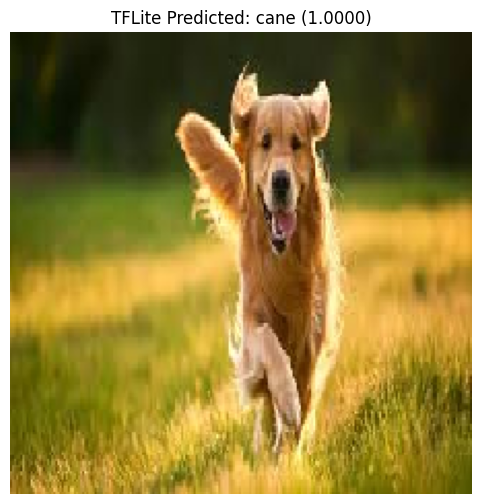

Prediksi TFLite: cane
Confidence: 1.0000

Probabilitas semua kelas (TFLite):
cane: 1.0000
cavallo: 0.0000
elefante: 0.0000
farfalla: 0.0000
gallina: 0.0000
gatto: 0.0000
mucca: 0.0000
pecora: 0.0000
ragno: 0.0000
scoiattolo: 0.0000
sayangin gguguk anda
jangan lupa kasih makan


In [ ]:
# Dari TFLite
class_name, confidence, predictions = infer_image(
    image_path="dog.jpeg",
    model_type="tflite",
    tflite_path="tflite/model.tflite",
    label_path="tflite/label.txt",
    img_size=(224, 224)
)


rekom(class_name)


